In [1]:
%matplotlib inline
import math
import pandas as pd
from tsmom_model import *
import numpy as np
from datetime import datetime
import PPCA_MR as p
import statsmodels.api as sm
import quandl
token="QWe8iSbyAFzRuod2aroM"

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import pylab
sns.set(font_scale=2)
pylab.rcParams['figure.figsize'] = (24, 18)

# Hand cleansed
Hand cleaned to removed duplicates

In [3]:
cleansed=load_amihud_markets_price()

tsmom_model.py:160: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('./Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:162: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('./liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


# Funding Rates

* TED spread

In [4]:
ted=quandl.get('FRED/TEDRATE',token=token).Value

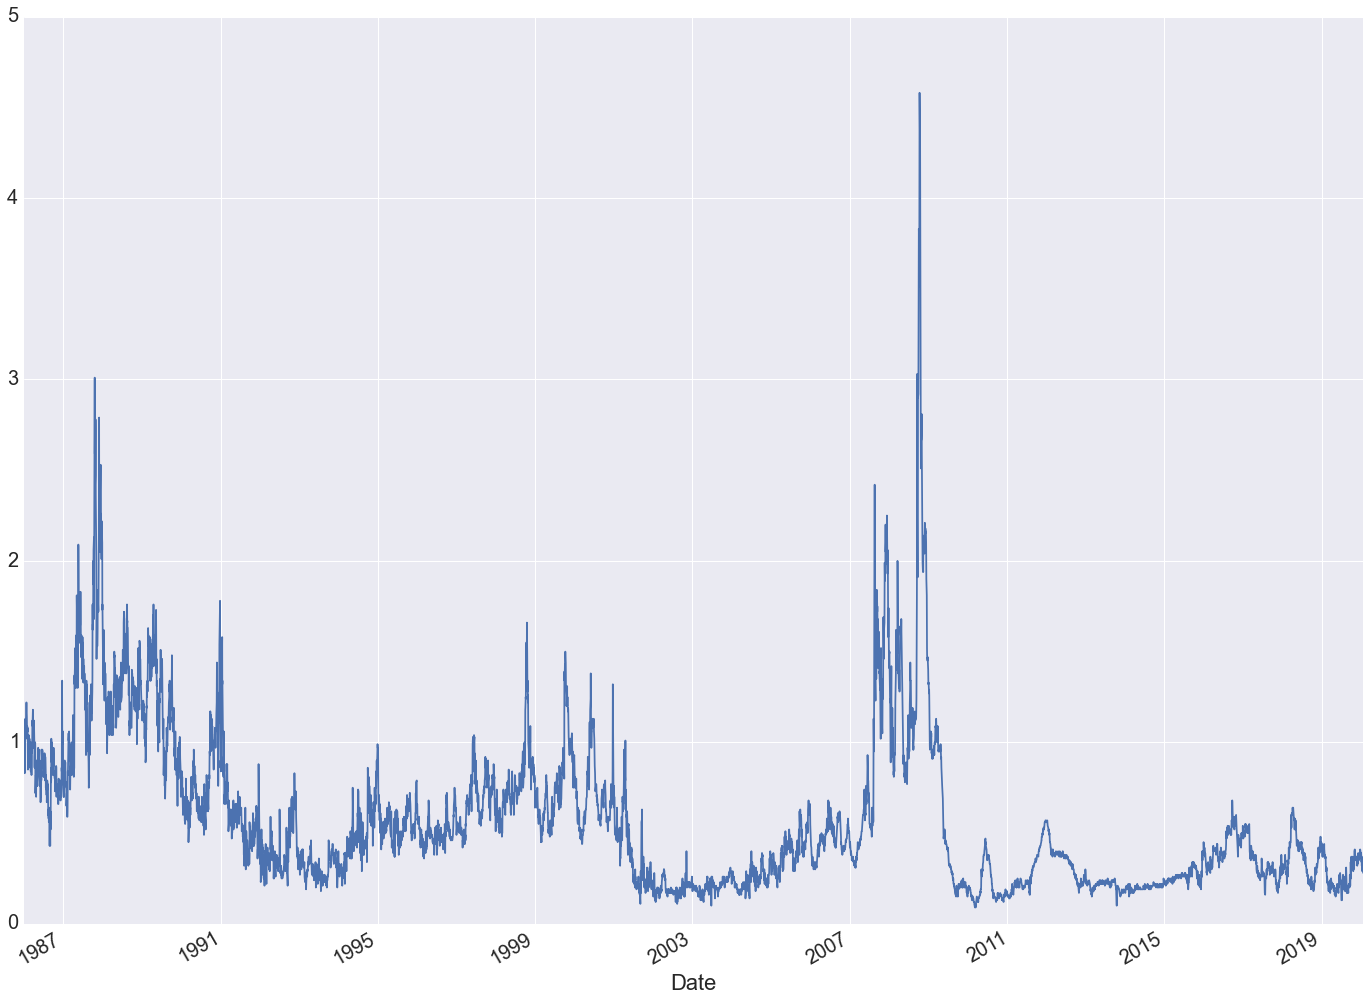

In [5]:
ted.plot()

# Swap versus cash financed

OIS - Tbills

* Missing OIS data

In [6]:
tbill=quandl.get('FRED/DTB3',token=token).Value

# Libor term repo

Overight - Repo rate

* Missing LIBOR O/N rate
* Ticker is FRED/USDONTDIS6N (or something similar)

In [7]:
libor=quandl.get('FRED/USDONTD156N',token=token).VALUE
repo=pd.read_csv('repo.csv',index_col=0,parse_dates=True)
# This needs to get replaced with 
libor_term_repo=(repo.TreasuryRepo-libor).dropna()

# On the run versus off the run 

In [8]:
us10y_zero=quandl.get('FED/SVENY',token=token).SVENY10.resample(rule='d',how='last').dropna()
yield10=quandl.get('USTREASURY/YIELD',token=token)['10 YR'].resample(rule='d',how='last').dropna()
on_off=(us10y_zero-yield10).dropna()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  


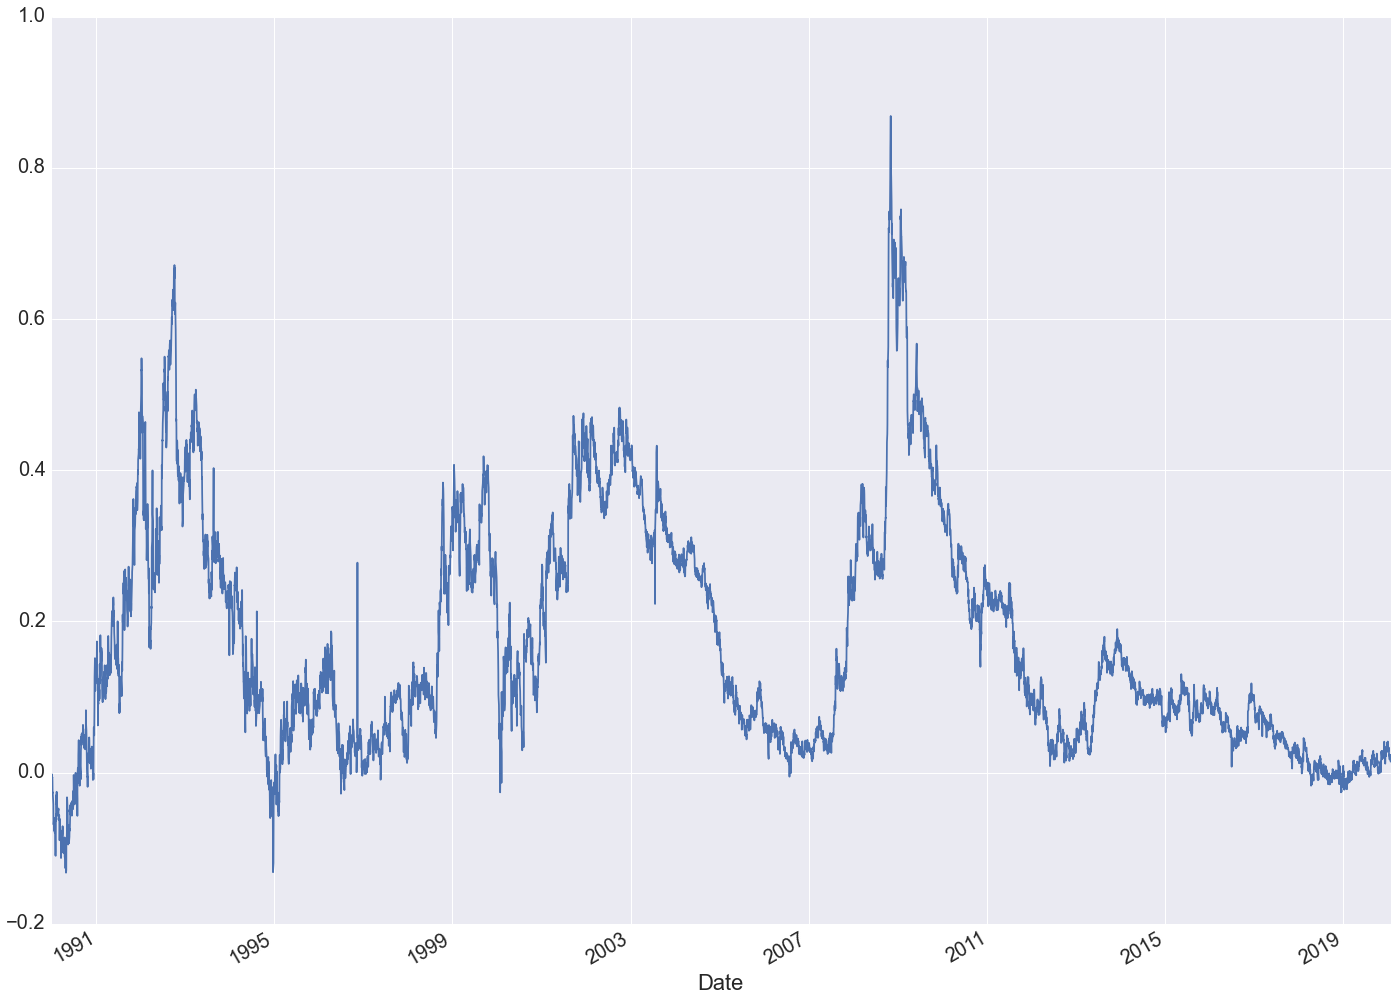

In [9]:
on_off.plot()

# Pastor and Stambagh  (2003)

https://faculty.chicagobooth.edu/lubos.pastor/research/liq_data_1962_2016.txt

In [10]:
PS=pd.read_csv('PS.csv',index_col=0,parse_dates=True).resample(rule='m',how='last')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.


# Getting everything ready for regressions

In [11]:
funding_liquidity = pd.DataFrame()
market_liquidity = pd.DataFrame()
funding_liquidity['TED Spread']=ted.resample(rule='m',how='last')/100.
funding_liquidity['LIBOR term repo']=libor_term_repo.resample(rule='m',how='last')/100.


/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  after removing the cwd from sys.path.


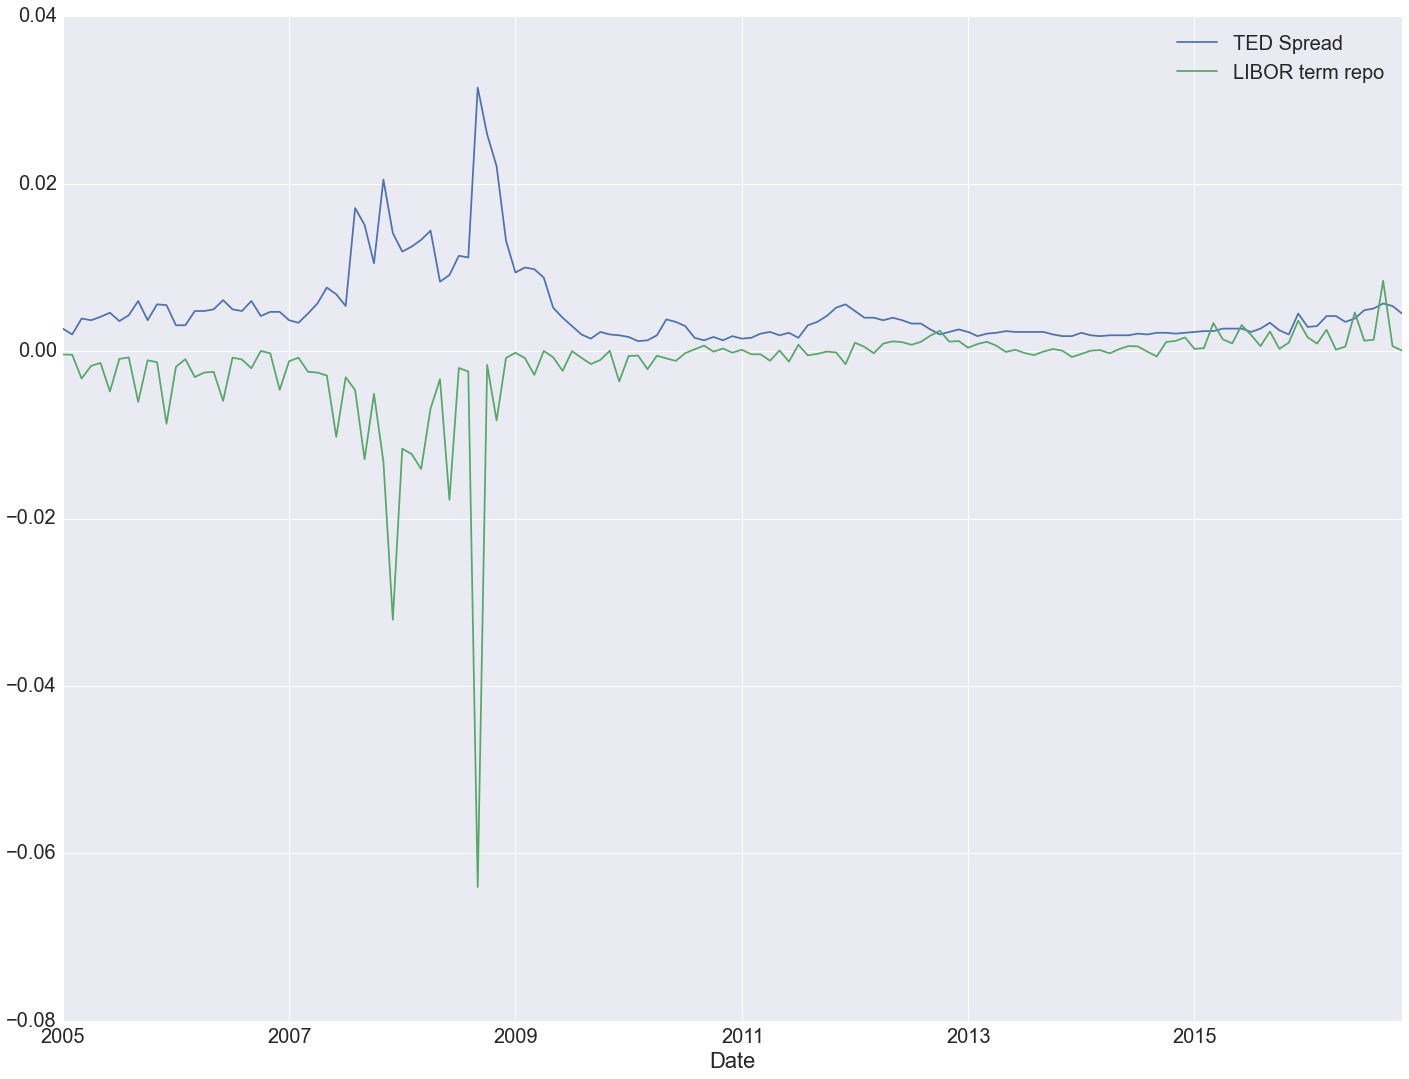

In [12]:
funding_liquidity.dropna().plot()

In [13]:
market_liquidity = pd.DataFrame()
market_liquidity['PS']=PS['Innovations in aggregate liquidity'].resample(rule='m',how='last')
market_liquidity['On versus off the run Treasuries']=on_off.resample(rule='m',how='last')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  This is separate from the ipykernel package so we can avoid doing imports until


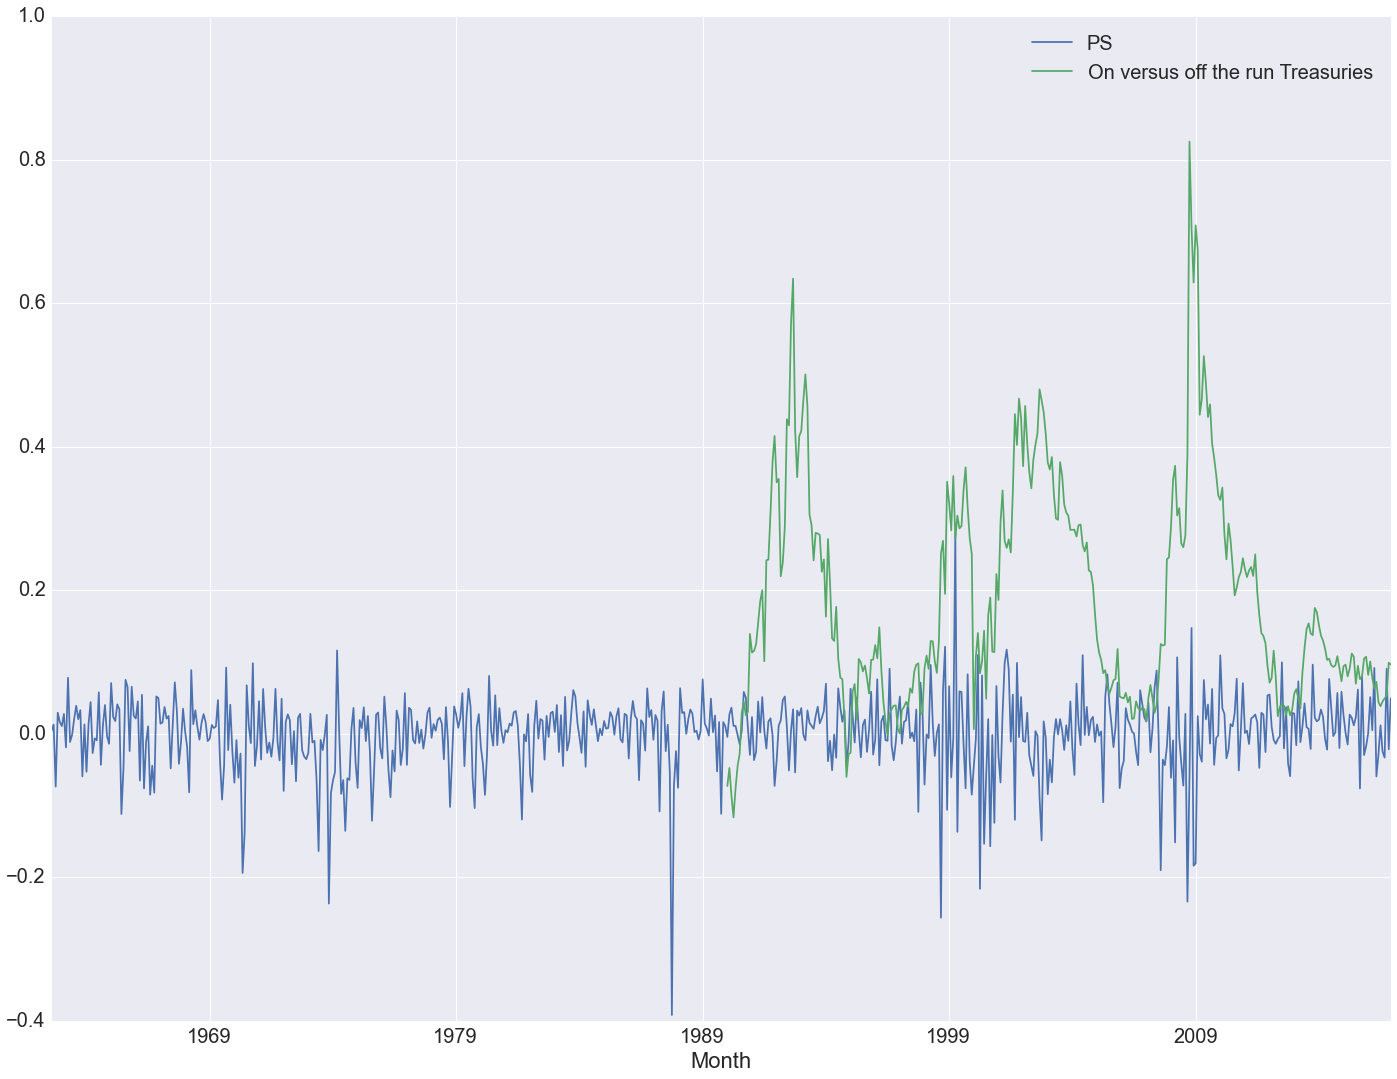

In [14]:
market_liquidity.plot()

# Determinents of Liquidity

In [15]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:44: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:46: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:48: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:48: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:51: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future ve

In [16]:
#data=calc_zscore_ew(amihud.dropna(how='all')).dropna(how='all')
data=calc_zscore_expanding_window(amihud.dropna(how='all'),3).dropna(how='all')

tsmom_model.py:325: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=3,window=100000000,center=False).mean()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)
tsmom_model.py:325: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=3,window=100000000,center=False).std()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)


In [17]:
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

In [18]:
sector_PC={}
sector_variance_explained=pd.DataFrame()

no_pc=3
for sect in d_map.keys():
    try: 
        PPCA=p.PPCA()
        PPCA.fit(np.array(sector_zscores[sect]),d=no_pc)
        sector_variance_explained[sect] = PPCA.var_exp
        pcs=pd.DataFrame()
        for i in range(0,no_pc,1):
            x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
            x.set_axis(sector_zscores[sect].index)
            pcs[i]=x
        sector_PC[sect] = pcs
    except:
        print sect

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [19]:
sector_PC.keys()

['Agriculturals',
 'Currencies',
 'Energies',
 'Equities',
 'Metals',
 'Fixed Income']

In [21]:
sector_factor=pd.DataFrame()
for s in ['Agriculturals',
         'Energies',
         'Equities',
         'Metals',
         'Fixed Income']:
    #sector_factor[s]=sector_PC[s].mean(axis=1)
    for i in sector_PC[s].columns:
        sector_factor['Amihud '+s+ ' '+str(i+1)]=sector_PC[s][i]

# Market Liqudity for Amihud common factors across asset classes




In [28]:
results_df=pd.DataFrame()
for reg_fact in market_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in sector_factor.columns:
        ind=sector_factor[s].index
        # Please make the fit robust 
        res=sm.OLS(sector_factor[s],sm.add_constant(market_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)

In [29]:
results_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
PS,0.716271,4.926459,0.121059,-0.606847,-0.062340,-0.591665,9.824916,-4.774306,0.439527,6.019002,3.651932,2.294423,-6.062318,-3.261795,-0.112020
PSTstats,0.201633,1.618567,0.081938,-0.409508,-0.053861,-0.668880,2.731736,-1.259033,0.419363,1.849107,2.184206,2.005319,-2.543171,-2.080206,-0.117483
On versus off the run Treasuries,-0.423838,-9.038441,-1.700526,1.247952,-0.363634,2.015932,-9.227678,1.956903,1.973787,-8.648899,0.771229,-1.998140,7.001667,2.726132,-0.283259
On versus off the run TreasuriesTstats,-0.172897,-10.248513,-2.845698,1.388222,-0.560155,3.791093,-5.875300,0.873236,3.939110,-6.842931,0.625356,-4.121389,9.658113,3.744377,-0.737320


# Funding Liqudity for Amihud common factors across asset classes

Note, since our repo data doesn't go back as long the we only look at it from 2005 to 2016



In [30]:
for reg_fact in funding_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in sector_factor.columns:
        ind2=funding_liquidity[reg_fact].dropna().index
        ind=sector_factor[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(sector_factor[s].loc[ind],sm.add_constant(funding_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)
results_df.set_axis(sector_factor.columns)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [31]:
results_df.T.round(2)

,Amihud Agriculturals 1,Amihud Agriculturals 2,Amihud Agriculturals 3,Amihud Energies 1,Amihud Energies 2,Amihud Energies 3,Amihud Equities 1,Amihud Equities 2,Amihud Equities 3,Amihud Metals 1,Amihud Metals 2,Amihud Metals 3,Amihud Fixed Income 1,Amihud Fixed Income 2,Amihud Fixed Income 3
PS,0.72,4.93,0.12,-0.61,-0.06,-0.59,9.82,-4.77,0.44,6.02,3.65,2.29,-6.06,-3.26,-0.11
PSTstats,0.20,1.62,0.08,-0.41,-0.05,-0.67,2.73,-1.26,0.42,1.85,2.18,2.01,-2.54,-2.08,-0.12
On versus off the run Treasuries,-0.42,-9.04,-1.70,1.25,-0.36,2.02,-9.23,1.96,1.97,-8.65,0.77,-2.00,7.00,2.73,-0.28
On versus off the run TreasuriesTstats,-0.17,-10.25,-2.85,1.39,-0.56,3.79,-5.88,0.87,3.94,-6.84,0.63,-4.12,9.66,3.74,-0.74
TED Spread,106.94,-65.67,13.77,-23.62,6.69,10.49,-124.53,333.26,-19.42,-189.00,-174.54,-8.72,131.84,69.19,29.49
TED SpreadTstats,1.53,-1.13,0.56,-1.13,0.37,0.64,-1.88,8.74,-0.74,-2.70,-8.81,-0.39,2.99,3.64,1.88
LIBOR term repo,15.45,-13.55,-6.36,43.75,9.97,-15.71,46.93,-152.13,-5.87,86.47,73.18,1.75,-62.41,-73.05,-0.24
LIBOR term repoTstats,0.40,-0.43,-0.72,2.14,0.83,-2.11,2.12,-7.68,-0.84,3.22,3.78,0.11,-2.86,-3.23,-0.07


In [32]:
print results_df.T.round(2).to_latex()

\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
{} &  Amihud Agriculturals 1 &  Amihud Agriculturals 2 &  Amihud Agriculturals 3 &  Amihud Energies 1 &  Amihud Energies 2 &  Amihud Energies 3 &  Amihud Equities 1 &  Amihud Equities 2 &  Amihud Equities 3 &  Amihud Metals 1 &  Amihud Metals 2 &  Amihud Metals 3 &  Amihud Fixed Income 1 &  Amihud Fixed Income 2 &  Amihud Fixed Income 3 \\
\midrule
PS                                     &                    0.72 &                    4.93 &                    0.12 &              -0.61 &              -0.06 &              -0.59 &               9.82 &              -4.77 &               0.44 &             6.02 &             3.65 &             2.29 &                  -6.06 &                  -3.26 &                  -0.11 \\
PSTstats                               &                    0.20 &                    1.62 &                    0.08 &              -0.41 &              -0.05 &              -0.67 &               2.73 &              -1.26 &     

# Run for unanticipated shocks from residuals from AR(2)

In [33]:
resid={}
for sector in sector_PC.keys():
    first_com=sector_PC[sector][0]
    temp=first_com.shift(2).dropna()
    #temp=first_com.diff().dropna()
    res=sm.OLS(temp,first_com.loc[temp.index]).fit()
    resid[sector]=res.resid
resid=pd.DataFrame(resid)

In [34]:
results_df=pd.DataFrame()
for reg_fact in market_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in resid.columns:
        ind=resid[s].index
        # Please make the fit robust 
        res=sm.OLS(resid[s],sm.add_constant(market_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)

In [35]:
for reg_fact in funding_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in resid.columns:
        ind2=funding_liquidity[reg_fact].dropna().index
        ind=resid[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(resid[s].loc[ind],sm.add_constant(funding_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)
results_df.set_axis(sector_factor.columns)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


ValueError: Length mismatch: Expected axis has 6 elements, new values have 15 elements

In [ ]:
results_df.T.round(2)

In [33]:
print results_df.T.round(2).to_latex()

\begin{tabular}{lrrrrrr}
\toprule
{} &      0 &      1 &      2 &      3 &      4 &      5 \\
\midrule
PS                                     &   2.41 &  -0.99 &  -1.20 &  -0.01 &   0.56 &  -0.73 \\
PSTstats                               &   1.14 &  -0.22 &  -0.86 &  -0.00 &   0.23 &  -0.25 \\
On versus off the run Treasuries       &  -0.57 &  -3.17 &  -0.03 &  -4.17 &   1.56 &   2.73 \\
On versus off the run TreasuriesTstats &  -0.46 &  -1.70 &  -0.06 &  -2.32 &   1.40 &   2.39 \\
TED Spread                             & -68.53 &  53.13 &  16.21 &  29.99 & -32.83 & -30.44 \\
TED SpreadTstats                       &  -1.45 &   0.66 &   1.05 &   0.66 &  -0.74 &  -0.57 \\
LIBOR term repo                        &  59.16 & -86.43 &  -1.58 & -26.87 &  51.59 &  52.55 \\
LIBOR term repoTstats                  &   3.52 &  -4.11 &  -0.22 &  -3.70 &   5.98 &   2.84 \\
\bottomrule
\end{tabular}



# FHT method

In [36]:
FHT=calculate_FHT(cleansed)

tsmom_model.py:360: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  nonzero=x[x==0].resample(rule='m',how='count')
tsmom_model.py:361: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  Z=(nonzero/x.resample(rule='m',how='count')).dropna()
tsmom_model.py:362: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')
tsmom_model.py:362: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')


In [37]:
data=calc_zscore_expanding_window(FHT.dropna(how='all'),3).dropna(how='all')

In [38]:
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

In [39]:
sector_PC={}
sector_variance_explained=pd.DataFrame()

no_pc=3
for sect in d_map.keys():
    try: 
        PPCA=p.PPCA()
        PPCA.fit(np.array(sector_zscores[sect]),d=no_pc)
        sector_variance_explained[sect] = PPCA.var_exp
        pcs=pd.DataFrame()
        for i in range(0,no_pc,1):
            x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
            x.set_axis(sector_zscores[sect].index)
            pcs[i]=x
        sector_PC[sect] = pcs
    except:
        print sect

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [41]:
sector_factor=pd.DataFrame()
for s in sector_PC.keys():
    for i in sector_PC[s].columns:
        sector_factor['FHT '+s+ ' '+str(i+1)]=sector_PC[s][i]

# Market liquidity
TODO: Make errors robus

In [42]:
results_df=pd.DataFrame()
for reg_fact in market_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in sector_factor.columns:
        ind2=market_liquidity[reg_fact].dropna().index
        ind=sector_factor[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(sector_factor[s].loc[ind],sm.add_constant(market_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys


In [43]:
results_df.T.round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
PS,4.64,-1.14,-1.54,7.27,-0.31,-0.66,-7.38,-1.61,-0.80,-16.74,-1.18,1.35,5.71,-1.98,-0.43,-8.84,-0.31,-0.33
PSTstats,1.56,-0.73,-1.19,2.29,-0.28,-0.88,-2.89,-1.85,-0.98,-3.08,-0.86,1.04,1.91,-1.20,-0.30,-2.50,-0.23,-0.29
On versus off the run Treasuries,-4.29,1.50,-0.15,-6.24,0.70,-0.45,3.31,-0.00,-0.04,8.71,-0.39,-0.14,-4.05,0.71,0.44,6.68,0.38,0.43
On versus off the run TreasuriesTstats,-3.90,2.06,-0.33,-3.74,1.11,-1.33,2.48,-0.01,-0.11,3.19,-0.62,-0.25,-2.39,1.02,0.86,6.54,0.70,0.85


In [44]:
for reg_fact in funding_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in sector_factor.columns:
        ind2=funding_liquidity[reg_fact].dropna().index
        ind=sector_factor[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(sector_factor[s].loc[ind],sm.add_constant(funding_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)
results_df.set_axis(sector_factor.columns)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [45]:
results_df.T.round(2)

,FHT Agriculturals 1,FHT Agriculturals 2,FHT Agriculturals 3,FHT Currencies 1,FHT Currencies 2,FHT Currencies 3,FHT Energies 1,FHT Energies 2,FHT Energies 3,FHT Equities 1,FHT Equities 2,FHT Equities 3,FHT Metals 1,FHT Metals 2,FHT Metals 3,FHT Fixed Income 1,FHT Fixed Income 2,FHT Fixed Income 3
PS,4.64,-1.14,-1.54,7.27,-0.31,-0.66,-7.38,-1.61,-0.80,-16.74,-1.18,1.35,5.71,-1.98,-0.43,-8.84,-0.31,-0.33
PSTstats,1.56,-0.73,-1.19,2.29,-0.28,-0.88,-2.89,-1.85,-0.98,-3.08,-0.86,1.04,1.91,-1.20,-0.30,-2.50,-0.23,-0.29
On versus off the run Treasuries,-4.29,1.50,-0.15,-6.24,0.70,-0.45,3.31,-0.00,-0.04,8.71,-0.39,-0.14,-4.05,0.71,0.44,6.68,0.38,0.43
On versus off the run TreasuriesTstats,-3.90,2.06,-0.33,-3.74,1.11,-1.33,2.48,-0.01,-0.11,3.19,-0.62,-0.25,-2.39,1.02,0.86,6.54,0.70,0.85
TED Spread,-202.89,-42.86,6.70,-272.24,45.36,26.50,199.52,10.90,47.49,538.68,85.25,24.92,-297.53,25.41,10.40,315.52,24.36,-34.01
TED SpreadTstats,-3.22,-1.64,0.27,-3.68,1.55,1.65,3.68,0.56,3.31,5.13,3.62,1.09,-4.62,0.90,0.43,6.59,1.02,-1.09
LIBOR term repo,142.93,0.24,33.22,133.74,-9.48,6.42,-82.97,-14.41,-37.44,-239.96,-20.13,3.98,156.31,2.54,-18.31,-207.49,5.80,-6.95
LIBOR term repoTstats,4.19,0.02,3.00,4.68,-0.79,0.37,-2.05,-0.91,-1.83,-5.72,-2.89,0.27,5.26,0.11,-1.18,-7.31,0.92,-0.93


In [46]:
print results_df.T.round(2).to_latex()

\begin{tabular}{lrrrrrrrrrrrrrrrrrr}
\toprule
{} &  FHT Agriculturals 1 &  FHT Agriculturals 2 &  FHT Agriculturals 3 &  FHT Currencies 1 &  FHT Currencies 2 &  FHT Currencies 3 &  FHT Energies 1 &  FHT Energies 2 &  FHT Energies 3 &  FHT Equities 1 &  FHT Equities 2 &  FHT Equities 3 &  FHT Metals 1 &  FHT Metals 2 &  FHT Metals 3 &  FHT Fixed Income 1 &  FHT Fixed Income 2 &  FHT Fixed Income 3 \\
\midrule
PS                                     &                 4.64 &                -1.14 &                -1.54 &              7.27 &             -0.31 &             -0.66 &           -7.38 &           -1.61 &           -0.80 &          -16.74 &           -1.18 &            1.35 &          5.71 &         -1.98 &         -0.43 &               -8.84 &               -0.31 &               -0.33 \\
PSTstats                               &                 1.56 &                -0.73 &                -1.19 &              2.29 &             -0.28 &             -0.88 &           -2.89 &        

# Run for unanticipated shocks from residuals from AR(2)


In [47]:
resid={}
for sector in sector_PC.keys():
    first_com=sector_PC[sector][0]
    temp=first_com.shift(2).dropna()
    #temp=first_com.diff().dropna()
    res=sm.OLS(temp,first_com.loc[temp.index]).fit()
    resid[sector]=res.resid
resid=pd.DataFrame(resid)

In [48]:
results_df=pd.DataFrame()
for reg_fact in market_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in resid.columns:
        ind2=market_liquidity[reg_fact].dropna().index
        ind=resid[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(resid[s].loc[ind],sm.add_constant(market_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys


In [49]:
for reg_fact in funding_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in resid.columns:
        ind2=funding_liquidity[reg_fact].dropna().index
        ind=resid[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(resid[s].loc[ind],sm.add_constant(funding_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)
results_df.set_axis(sector_factor.columns)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


ValueError: Length mismatch: Expected axis has 6 elements, new values have 18 elements

In [50]:
results_df.T.round(2)

,0,1,2,3,4,5
PS,1.04,-1.24,2.48,-4.29,3.39,2.51
PSTstats,0.49,-0.38,1.25,-0.68,1.30,0.75
On versus off the run Treasuries,-2.67,-3.47,1.68,6.27,2.52,-2.08
On versus off the run TreasuriesTstats,-2.51,-2.36,1.64,2.44,2.18,-1.46
TED Spread,-101.35,-4.65,32.28,171.44,46.24,-78.52
TED SpreadTstats,-1.76,-0.06,0.72,1.38,0.74,-1.12
LIBOR term repo,-9.59,-52.43,11.63,-7.94,19.62,-30.25
LIBOR term repoTstats,-0.47,-1.43,0.45,-0.17,0.60,-0.96


In [48]:
print results_df.T.round(2).to_latex()

\begin{tabular}{lrrrrrr}
\toprule
{} &  Agriculturals &  Currencies &  Energies &  Equities &  Metals &  Fixed Income \\
\midrule
PS                                     &           1.05 &       -1.24 &      2.49 &      4.29 &   -3.41 &          2.51 \\
PSTstats                               &           0.49 &       -0.38 &      1.25 &      0.68 &   -1.32 &          0.75 \\
On versus off the run Treasuries       &          -2.67 &       -3.48 &      1.68 &     -6.27 &   -2.50 &         -2.08 \\
On versus off the run TreasuriesTstats &          -2.51 &       -2.36 &      1.64 &     -2.44 &   -2.17 &         -1.46 \\
TED Spread                             &        -101.29 &       -4.62 &     32.27 &   -171.35 &  -44.94 &        -78.51 \\
TED SpreadTstats                       &          -1.76 &       -0.06 &      0.72 &     -1.38 &   -0.72 &         -1.12 \\
LIBOR term repo                        &          -9.56 &      -52.48 &     11.65 &      7.94 &  -20.76 &        -30.24 \\
LIBOR ter